# Acidentes nas rodovias federais

Temos como objetivo analisar os acidentes rodovias federais Brasil Jan/07 a Dez/20 e buscar insights referentes às condições de segurança das estradas e de motoristas brasileiros.

![img](https://raw.githubusercontent.com/fervassoler/estudos-analise-dados/main/acidentes_rodovias_brasil/dataset-cover.jpg)

## Libs

In [1]:
import os
import pandas as pd
import unicodedata

## Funções

In [2]:
def trata_unicode(text):
    
    if type(text) == float:
        text=''
    try:
        result = text.encode('iso-8859-1').decode('utf8')
        return result
    except:
        pass
    
    return text

In [3]:
def remover_outliers(data, colunas, n_dp):
    """ recebe os dados e a coluna para remover o outlier e 
    o número de desvios padrão a ser considerado.

    data: dados
    coluna: coluna a ser analisada
    n_dp: número de desvios padrão a ser considerados
    """
    index_to_delete = []
    for col in colunas:
        
        data[col].std()
        data[col].mean()

        dp = data[col].std()
        media = data[col].mean()

        acima_dp = media + (6 * dp)
        abaixo_dp = media - (6 * dp)

        index_col = data[~(data[col] < acima_dp) &
                          (data[col] > abaixo_dp)].index

        index_to_delete.extend(index_col)
    
    index_to_delete = list(dict.fromkeys(index_to_delete))
    
    return index_to_delete

## Dados

Estes dados foram extraídos do do Kaggle [aqui nesse link](https://www.kaggle.com/datasets/equeiroz/acidentes-rodovias-federais-brasil-jan07-a-jul19)
<br>

Dados da Polícia Rodoviária Federal: https://portal.prf.gov.br/dados-abertos
Cada registro corresponde a uma ocorrência (acidente), incluindo dados de localidade, nome da BR, km, condições meteorológicas e da estrada, horário, causa e tipo do acidente, quantidades de feridos e mortos.

In [4]:
dados = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    
        # leitura dos dados
        df = pd.read_csv(os.path.join(dirname, filename), encoding='latin-1', sep=";", engine='python')
        dados.append(df)
dados = pd.concat(dados, ignore_index=True)

/kaggle/input/acidentes-rodovias-federais-brasil-jan07-a-jul19/datatran2015.csv
/kaggle/input/acidentes-rodovias-federais-brasil-jan07-a-jul19/datatran2016.csv
/kaggle/input/acidentes-rodovias-federais-brasil-jan07-a-jul19/datatran2011.csv
/kaggle/input/acidentes-rodovias-federais-brasil-jan07-a-jul19/datatran2017.csv
/kaggle/input/acidentes-rodovias-federais-brasil-jan07-a-jul19/datatran2018.csv
/kaggle/input/acidentes-rodovias-federais-brasil-jan07-a-jul19/datatran2009.csv
/kaggle/input/acidentes-rodovias-federais-brasil-jan07-a-jul19/datatran2012.csv
/kaggle/input/acidentes-rodovias-federais-brasil-jan07-a-jul19/datatran2010.csv
/kaggle/input/acidentes-rodovias-federais-brasil-jan07-a-jul19/datatran2008.csv
/kaggle/input/acidentes-rodovias-federais-brasil-jan07-a-jul19/datatran2013.csv
/kaggle/input/acidentes-rodovias-federais-brasil-jan07-a-jul19/datatran2020.csv
/kaggle/input/acidentes-rodovias-federais-brasil-jan07-a-jul19/datatran2007.csv
/kaggle/input/acidentes-rodovias-federai

In [5]:
dados.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,83298209.0,2015-01-01,Quinta,00:05:00,RJ,101,327.0,NITEROI,Outras,Colisão traseira,...,0,2,0,0,2,NaN,NaN,NaN,NaN,NaN
1,83298218.0,2015-01-01,Quinta,01:20:00,MS,163,434.4,CAMPO GRANDE,Animais na Pista,Saída de Pista,...,0,1,0,1,1,NaN,NaN,NaN,NaN,NaN
2,83298220.0,2015-01-01,Quinta,01:45:00,RJ,40,64.0,PETROPOLIS,Outras,Colisão com objeto fixo,...,0,2,0,0,2,NaN,NaN,NaN,NaN,NaN
3,83298221.0,2015-01-01,Quinta,02:50:00,SC,101,356.1,SANGAO,Falta de atenção,Saída de Pista,...,0,0,0,4,1,NaN,NaN,NaN,NaN,NaN
4,83298222.0,2015-01-01,Quinta,02:50:00,RS,101,25.9,TRES CACHOEIRAS,Falta de atenção,Saída de Pista,...,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN


In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1784454 entries, 0 to 1784453
Data columns (total 31 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   id                      float64
 1   data_inversa            object 
 2   dia_semana              object 
 3   horario                 object 
 4   uf                      object 
 5   br                      object 
 6   km                      object 
 7   municipio               object 
 8   causa_acidente          object 
 9   tipo_acidente           object 
 10  classificacao_acidente  object 
 11  fase_dia                object 
 12  sentido_via             object 
 13  condicao_metereologica  object 
 14  tipo_pista              object 
 15  tracado_via             object 
 16  uso_solo                object 
 17  ano                     float64
 18  pessoas                 int64  
 19  mortos                  int64  
 20  feridos_leves           int64  
 21  feridos_graves          int64  

## Pré processamento dos dados

- Alguns dados da coluna `data_inversa` estão com formatação diferentes de datas, e não estão no formato datetime, por isso vou ajustar para que todos fiquem no mesmo padrão em uma nova coluna chamada `data_hora` já incluindo também o horário 

In [7]:
dados['data_hora'] = dados['data_inversa']+' ' +dados['horario']
dados['data_hora'] = pd.to_datetime(dados['data_hora'], infer_datetime_format=True)

- Vou considerar que a soma de mortos, feridos_leves e feridos_graves devem representar o total de feridos.
- Vou considerar que o total de pessoas é a soma de mortos, feridos_leves, feridos_graves, ilesos e ignorados

Obs: Onde a soma de pessoas for resultante em 0 excluir linha (11 casos)

In [8]:
dados['feridos'] = dados['mortos'] + dados['feridos_leves'] + dados['feridos_graves']
dados['pessoas'] = dados['mortos'] + dados['feridos_leves'] + dados['feridos_graves'] + dados['ilesos'] + dados['ignorados']

- Essas serão as colunas que irei utilizar para seguir a análise:

In [9]:
dados = dados[['dia_semana', 'uf', 'br', 'km', 'municipio', 'causa_acidente',  'tipo_acidente', 'classificacao_acidente', 'fase_dia', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 'ano', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos', 'feridos', 'ignorados','data_hora']]

Vou aplicar algumas normalizações textuais para agrupar mais itens de mesmo valor futuramente

In [10]:
# colunas com textos para normalizar
columns = ['dia_semana', 'uf', 'municipio', 'causa_acidente', 'tipo_acidente',
           'classificacao_acidente', 'fase_dia', 'condicao_metereologica', 'tipo_pista',
           'tracado_via', 'uso_solo']

for colum in columns:
    # trata unicodes divergentes e espaços a mais
    dados[colum] = dados[colum].apply(lambda x: trata_unicode(x).strip())
    
    # normaliza texto para minúsculo
    dados[colum] = dados[colum].apply(lambda x: x.lower())

**Analisando Outliers**

In [11]:
dados.describe()

,ano,pessoas,mortos,feridos_leves,feridos_graves,ilesos,feridos,ignorados
count,1.465837e+06,1.784454e+06,1.784454e+06,1.784454e+06,1.784454e+06,1.784454e+06,1.784454e+06,1.784454e+06
mean,2.011082e+03,2.177088e+00,5.250121e-02,4.919135e-01,1.737131e-01,1.367224e+00,7.181278e-01,9.173618e-02
std,2.412219e+00,1.596769e+00,2.866305e-01,9.960312e-01,5.663299e-01,1.254949e+00,1.266368e+00,3.876237e-01
min,2.007000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.009000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,2.011000e+03,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,2.013000e+03,2.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00
max,2.015000e+03,2.480000e+02,3.300000e+01,5.800000e+01,2.220000e+02,9.900000e+01,2.450000e+02,8.600000e+01


In [12]:
import seaborn as sns
import numpy as np

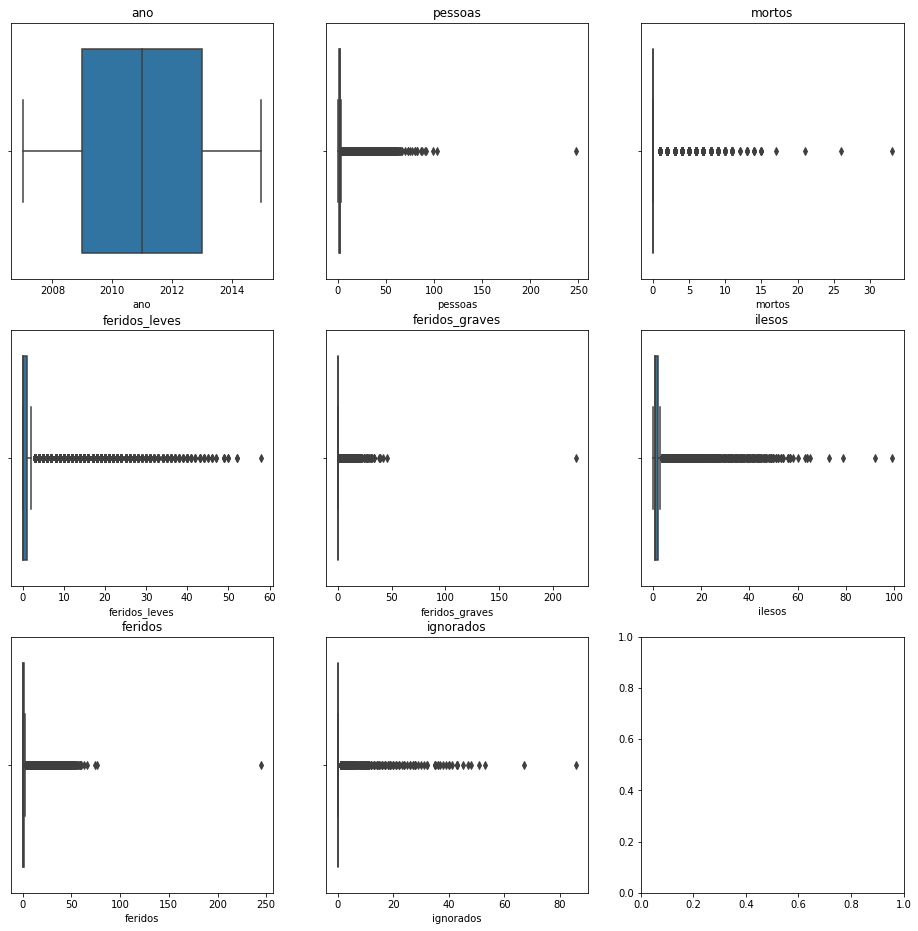

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(16, 16))

# seleciona apenas colunas que contém número
for i, column in enumerate(dados.select_dtypes(include=np.number).columns.tolist()):

    ax = axes[i//3,i%3]
    axes[i//3,i%3].set_title(column)
    sns.boxplot(x=dados[column],ax=ax)

Temos muitos outliers em nossos dados, vamos precisar levar isso em consideração para realizar algumas das análises e ter um valor mais próximo ao real e menos distorcido pela média.

In [14]:
#remove outliers com até 8 desvios padrões
colunas_outliers = ['pessoas', 'feridos_graves', 'feridos', 'ignorados','ilesos', 'mortos']

#dados sem outliers
index_remover = remover_outliers(dados, colunas_outliers, 8)
dados_so = dados.drop(index_remover).copy()

In [15]:
# remove pessoas onde o número de pessoas é igual a 0
dados_so.drop(dados_so[dados_so['pessoas'] == 0].index, inplace=True)

Após a remoção de até 8 desvios padrões

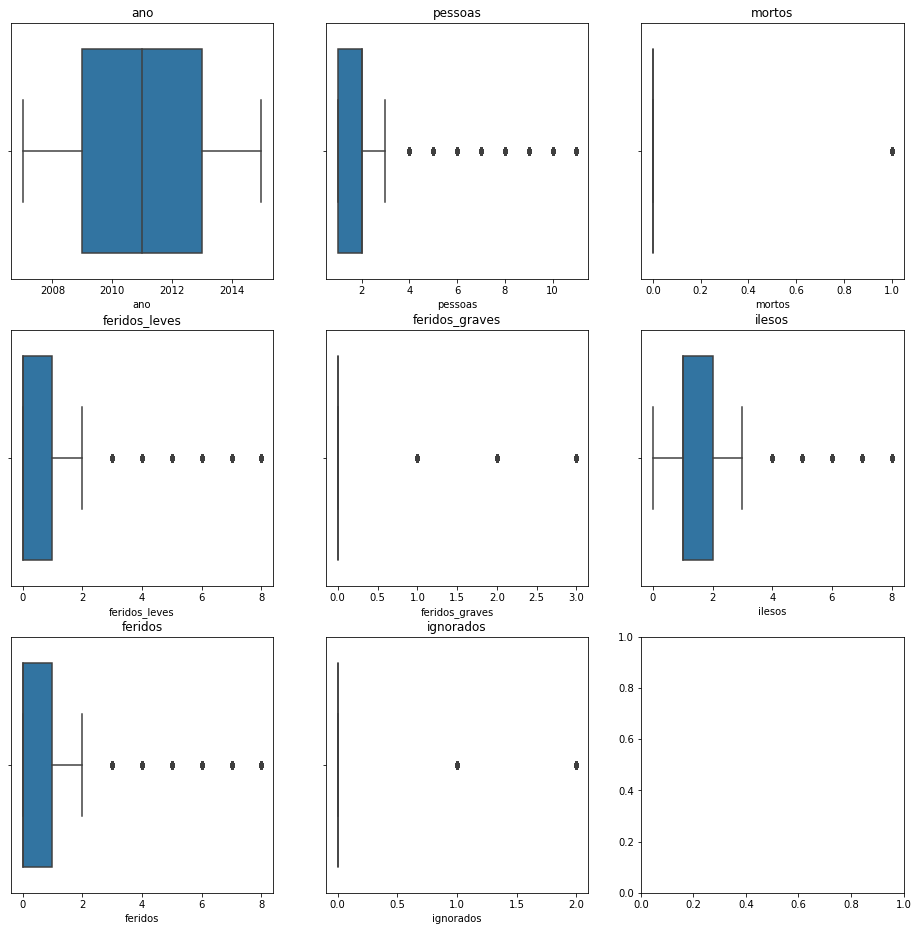

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(16, 16))

# seleciona apenas colunas que contém número
for i, column in enumerate(dados_so.select_dtypes(include=np.number).columns.tolist()):

    ax = axes[i//3,i%3]
    axes[i//3,i%3].set_title(column)
    sns.boxplot(x=dados_so[column],ax=ax)

In [17]:
rm = 100 - (dados_so.shape[0] * 100)/dados.shape[0]
print(f'Foram removidos {round(rm,2)}% da base de dados')

Foram removidos 1.19% da base de dados


**Acidentes mais graves costumam ser os que envolvem maior número de mortos e feridos e menor número de ilesos com isso vou adicionar pesos nos feridos, mortos, e ilesos para calcular a gravidade de um acidente**

- `ilesos` ou `ignorados` = sem peso
- `feridos_leves` = peso 2
- `feridos_graves` = peso 4
- `mortos` = peso 8

<br>
a gravidade vai ser calculada com base no percentual de pessoas feridas vezes o peso dos incidentes que levaram aos ferimentos ou morte, vou classificar a gravidade em: - muito grave
- grave 
- médio
- leve

In [18]:
dados_so['percentual_feridos'] = (dados_so['feridos'] * 100)/dados_so['pessoas']

dados_so['pesos'] = (dados_so['feridos_leves']*2) + (dados_so['feridos_graves']*4) + (dados_so['mortos']*8)

# peso da gravidade
dados_so['peso_gravidade'] = dados_so['percentual_feridos'] * dados_so['pesos']

# cria 4 categorias para o peso da gravidade
dados_so['gravidade'] = pd.cut(dados_so['peso_gravidade'],4, labels=['leve', 'médio', 'grave', 'muito_grave']).astype(str)

## Análise Exploratória

Temos dois tipos de cenários principais nos casos de acidentes, um em que há feridos e outro onde não houveram feridos,podemos classificar alguns tipos de gravidade para estes acidentes levando em consideração o número de mortos, e feridos, assim como a quantidade de pessoas envolvidas no acidente, baseado nessas principais características vamos responder algumas perguntas sobre estes cenários.
<br>
<br>

- **Qual o percentual de gravidade dos acidentes?**
- **Em quais regiões mais ocorreram acidentes graves?**
- **Dos acidentes graves, quais foram as principais causas?**
- **Os acidentes com vítimas fatais aumentaram ou diminuiram ao passar dos anos?**
- **Quais causas mais aumentaram ao passar dos anos que levaram a vítimas fatais?**
- **Dos acidentes sem feridos quantos foram graves?**
- **Dos acidentes sem feridos quais foram as principais causas?**
- **Entere ambos cenários, com feridos e sem feridos quais eram as condições climáticas mais frequentes?**

<br>

### Qual o percentual de gravidade dos acidentes?

In [19]:
#separa os pesos máximos de cada tipo de gravidade e as cores que serão adicionadas ao gráfico
gravidades = {}
cores = ['green', 'olive','orange','red']
i=0
for gravidade in dados_so['gravidade'].unique():
    peso_max = dados_so[dados_so['gravidade'] == gravidade]['peso_gravidade'].max()
    gravidades[gravidade] = [peso_max, cores[i]]
    i+=1
print(gravidades)

{'leve': [700.0, 'green'], 'médio': [1400.0, 'olive'], 'grave': [2100.0, 'orange'], 'muito_grave': [2800.0, 'red']}


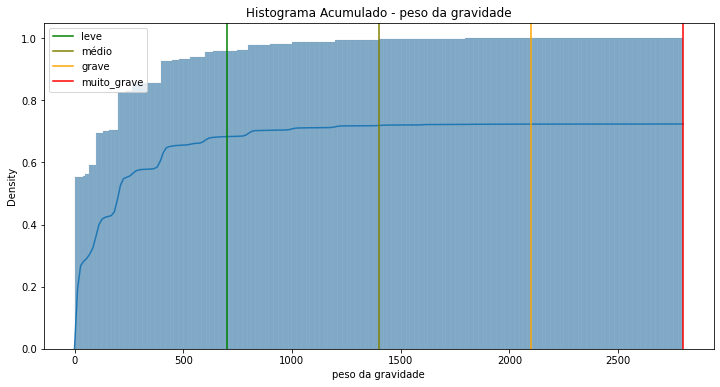

In [20]:
ax = sns.histplot(x = dados_so['peso_gravidade'], 
                  data = dados_so, 
                  kde = True, 
                  cumulative = True,
                  stat = 'density')
ax.figure.set_size_inches(12, 6)
ax.set_title("Histograma Acumulado - peso da gravidade")
ax.set_xlabel("peso da gravidade")

for g in gravidades:
    ax.axvline(gravidades[g][0], color=gravidades[g][1], linestyle="-", label=g)
ax.legend()
ax;

**Podemos ver que a maior parte do acidentes quase 96% são acidentes que podem ser considerados leves, 4% médios e menos que 0% graves e muito graves**

In [21]:
round(dados_so['gravidade'].value_counts(normalize=True),2)*100

leve           96.0
médio           4.0
grave           0.0
muito_grave     0.0
Name: gravidade, dtype: float64

### Em quais regiões mais ocorreram acidentes graves?

Nesse momento não irei levar em consideração a densidade demográfica de cada região, mas apenas o número de acidentes

In [22]:
regioes = {'norte': ['ap', 'ac', 'pa', 'ro', 'to', 'rr', 'am'],
           'nordeste':['ba','pe','ce', 'se', 'ma', 'rn', 'pb', 'pi','al'],
           'sul':['sc','pr','rs'],
           'sudeste':['sp','rj','es','mg'],
           'centro-oeste':['ms', 'mt', 'go', 'df']}

In [23]:
dados_so['regiao'] = ''
for regiao in regioes:
    dados_so.loc[dados_so['uf'].isin(regioes[regiao]),'regiao'] = regiao

In [24]:
acidentes_graves = dados_so[(dados_so['gravidade'] == 'grave') |
                            (dados_so['gravidade'] == 'muito grave')].copy()

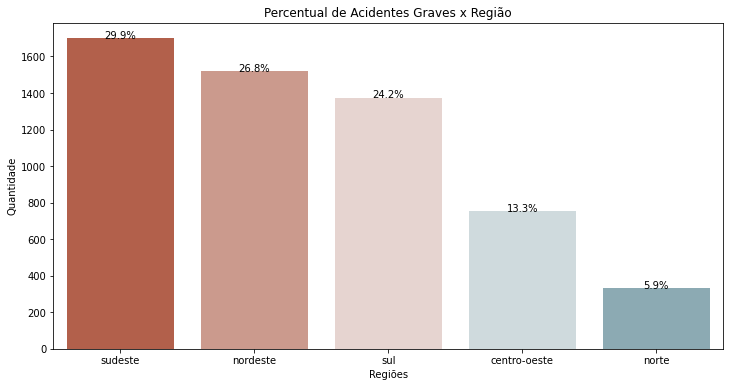

In [25]:
#cor do gráfico
plt.figure(figsize=(12, 6))

palette = sns.diverging_palette(220, 20, as_cmap=False)
palette.reverse()

ax = sns.countplot(x='regiao',
                   data=acidentes_graves,
                   order = acidentes_graves['regiao'].value_counts().index,
                   palette=palette)

plt.title('Percentual de Acidentes Graves x Região')
plt.xlabel('Regiões')
plt.ylabel('Quantidade')

# monta percentual acima das barras
total = len(acidentes_graves['regiao'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')

### Dos acidentes graves, quais foram as principais causas?

### Os acidentes com vítimas fatais aumentaram ou diminuiram ao passar dos anos?

### Quais causas mais aumentaram ao passar dos anos que levaram a vítimas fatais?

### Dos acidentes sem feridos quantos foram graves?

### Dos acidentes sem feridos quais foram as principais causas?

### Entere diferentes cenários, com feridos e sem feridos quais eram as condições climáticas mais frequentes?